# Importation des données

##  Librairies (Il y en a surement trop)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import pairwise_distances
import networkx as nx
import itertools
from networkx.drawing.nx_agraph import graphviz_layout
from __future__ import division 
import collections
from networkx.algorithms.richclub import rich_club_coefficient 
import seaborn as sns 
import random 
import math
from operator import itemgetter
from community import community_louvain
from networkx.algorithms import community
from itertools import count
import community

## Données de R

In [2]:
data = pd.read_csv('data.txt', sep="\t")

In [3]:
data.head()

,ID,QAStart,QEnd,SAStart,SEnd
1,1,403127,571184,1,168094
2,2,3774352,3945667,3347618,3518980
3,3,4502860,4651368,4237466,4385991
4,4,1147883,1290190,733701,874035
5,5,2771520,2885776,2355383,2469606


*Id est juste équivalent au numéro de la ligne ce sera plus simple pour nommer les noeuds*

# Exemple jouet

In [118]:
d_jouet = {'ID': ["A", "B", "C","D","E"], 'QAStart': [0, 2,4,6, 8],'QEnd': [1, 3,5,7,9] ,'SAStart': [4,6,3,1, 8], 'SEnd': [5, 7,2,0, 9] }
df_jouet=  pd.DataFrame(data=d_jouet)
df_jouet

,ID,QAStart,QEnd,SAStart,SEnd
0,A,0,1,4,5
1,B,2,3,6,7
2,C,4,5,3,2
3,D,6,7,1,0
4,E,8,9,8,9


# Création du graph

## Recherche des arc

### Jeu jouet

In [248]:
def find_edges(S,E, ref = True):
    l = []
    t= S+E
    #print('t',t)
    max_l  = max(t)
    #print( 'max_l',max_l)
    max_lID  = t.index(max_l)
    if max_lID < len(t)/2 :
        state_maxl = "S"
    else :
        state_maxl = "E"

    min_l = min(t)
    #print( 'min_l',min_l)
    min_lID  = t.index(min_l)
    if min_lID < len(t)/2 :
        state_minl = "S"
    else :
        state_minl = "E"
        
    T = []
    for i in range(len(t)):
        if i < len(t)/2 :
            T.append([t[i],'S'])
        else :
            T.append([t[i],'E'])
            
    #print('Len T', len(t))
    #print('T', T)
    for i in range(len(t)):
        D = []  
        dist =[]
        for j in range(len(t)):
            #print('HERE')
            
            #print('t.index(t[i])!= t.index(t[j]',t.index(t[i]), t.index(t[j]) )
            if t.index(t[i]) + len(t)/2!= t.index(t[j]) and t.index(t[i])!= t.index(t[j])  :
                if t[i] != max_l and t[i] != min_l and t[j] != max_l and t[j] != min_l : 
                    #print('t[i]', t[i], 't[j]', t[j])
                    #print(t[i]==min_l)
                    d =abs( t[j]- t[i]) 
                    D.append([d, t[j], t[i] ,T[j][1] ,  T[i][1] ])  
                    dist.append(d) 
              
                else :
                    if ref == True :
                        if state_maxl =="E" and state_minl == "S" :
                            #print('in state_maxl =="E" and state_minl == "S" ')
                            p1 = list(df_jouet["ID"][df_jouet["QEnd"]==max_l] )[0]
                            p1 = "E"+str(p1)
                            p2 = list(df_jouet["ID"][df_jouet['QAStart']==min_l] )[0]
                            p2 = "S"+str(p2)
                            if (p1, p2) not in l and (p2, p1) not in l:
                                l.append((p1 ,p2) )
                                #print('l[-1]', l[-1])
                        elif state_maxl =="S" and state_minl == "E" :
                            #print('in state_maxl =="S" and state_minl == "E"')
                            p1 = list(df_jouet["ID"][df_jouet["QAStart"]==max_l] )[0]
                            p1 = "S"+str(p1)
                            p2 = list(df_jouet["ID"][df_jouet['QEnd']==min_l] )[0]
                            p2 = "E"+str(p2)
                            if (p1, p2) not in l and (p2, p1) not in l:
                                l.append((p1 ,p2) )
                                #print('l[-1]', l[-1])
                        elif state_maxl =="S" and state_minl == "S" :
                            #print('in state_maxl =="S" and state_minl == "S"')
                            p1 = list(df_jouet["ID"][df_jouet["QAStart"]==max_l] )[0]
                            p1 = "S"+str(p1)
                            p2 = list(df_jouet["ID"][df_jouet['QAStart']==min_l] )[0]
                            p2 = "S"+str(p2)
                            if (p1, p2) not in l and (p2, p1) not in l:
                                l.append((p1 ,p2) )
                                #print('l[-1]', l[-1])
                        else :
                            #print('in else ')
                            p1 = list(df_jouet["ID"][df_jouet["QEnd"]==max_l] )[0]
                            p1 = "E"+str(p1)
                            p2 = list(df_jouet["ID"][df_jouet['QEnd']==min_l] )[0]
                            p2 = "E"+str(p2)
                            if (p1, p2) not in l and (p2, p1) not in l:
                                l.append((p1 ,p2) )
                                #print('l[-1]', l[-1])
                    else :
                        if state_maxl =="E" and state_minl == "S" :
                            #print('in state_maxl =="E" and state_minl == "S" ')
                            p1 = list(df_jouet["ID"][df_jouet["SEnd"]==max_l] )[0]
                            p1 = "E"+str(p1)
                            p2 = list(df_jouet["ID"][df_jouet['SAStart']==min_l] )[0]
                            p2 = "S"+str(p2)
                            if (p1, p2) not in l and (p2, p1) not in l:
                                l.append((p1 ,p2) )
                            #print('l[-1]', l[-1])
                        elif state_maxl =="S" and state_minl == "E" :
                            #print('in state_maxl =="S" and state_minl == "E"')
                            p1 = list(df_jouet["ID"][df_jouet["SAStart"]==max_l] )[0]
                            p1 = "S"+str(p1)
                            p2 = list(df_jouet["ID"][df_jouet['SEnd']==min_l] )[0]
                            p2 = "E"+str(p2)
                            if (p1, p2) not in l and (p2, p1) not in l:
                                l.append((p1 ,p2) )
                            #print('l[-1]', l[-1])
                        elif state_maxl =="S" and state_minl == "S" :
                            #print('in state_maxl =="S" and state_minl == "S"')
                            p1 = list(df_jouet["ID"][df_jouet["SAStart"]==max_l] )[0]
                            p1 = "S"+str(P1)
                            p2 = list(df_jouet["ID"][df_jouet['SAStart']==min_l] )[0]
                            p2 = "S"+str(P2)
                            if  (p1, p2) not in l and (p2, p1) not in l:
                                l.append((p1 ,p2) )
                            #print('l[-1]', l[-1])
                        else :
                            #print('in else')
                            p1 = list(df_jouet["ID"][df_jouet["SEnd"]==max_l] )[0]
                            p1 = "E"+str(p1)
                            p2 = list(df_jouet["ID"][df_jouet['SEnd']==min_l] )[0]
                            p2 = "E"+str(p2)
                            if  (p1, p2) not in l and (p2, p1)not in l:
                                l.append((p1 ,p2) )
                            #print('l[-1]', l[-1])
                    
            else :
                D.append(['NA', 'NA', 'NA', "NA", 'NA'])
                dist.append('NA')
    
        
   
        minD_ID = D[dist.index(min(dist))]
        #print('minD_ID' , minD_ID)  
        if 'NA' not in minD_ID :
            if ref == True :
                if  minD_ID[3] == 'E' and minD_ID[4] == 'S' :
                    p1 = list(df_jouet["ID"][df_jouet["QEnd"]==minD_ID[1]])[0]
                    p2 = list(df_jouet["ID"][df_jouet["QAStart"]== minD_ID[2]])[0]
                    if p1 != p2 :
                        p1 = "E"+str(p1)
                        p2 = "S"+str(p2)
                        if  (p1, p2) not in l and (p2, p1) not in l:
                            l.append((p1 ,p2) )
                elif minD_ID[3] == 'S' and minD_ID[4] == 'E' :
                    p1 = list(df_jouet["ID"][df_jouet["QAStart"]==minD_ID[1]])[0]
                    p2 = list(df_jouet["ID"][df_jouet["QEnd"]== minD_ID[2]])[0]
                    if p1 != p2 :
                        p1 = "S"+str(p1)
                        p2 = "E"+str(p2)
                        if  (p1, p2) not in l and (p2, p1) not in l:
                            l.append((p1 ,p2) )
                elif minD_ID[3] == 'S' and minD_ID[4] == 'S':
                    #print("HERE")
                    p1 = list(df_jouet["ID"][df_jouet["QAStart"]==minD_ID[1]])[0]
                    p2 = list(df_jouet["ID"][df_jouet["QAStart"]== minD_ID[2]])[0]
                    if p1 != p2 :
                        p1 = "S"+str(p1)
                        p2 = "S"+str(p2)
                        if  (p1, p2) not in l and (p2, p1) not in l:
                            l.append((p1 ,p2) )
                else :
                    p1 = list(df_jouet["ID"][df_jouet["QEnd"]==minD_ID[1]])[0]       
                    p2 = list(df_jouet["ID"][df_jouet["QEnd"]== minD_ID[2]])[0]
                    if p1 != p2 :
                        p1 = "E"+str(p1)
                        p2 = "E"+str(p2)
                        if  (p1, p2) not in l and (p2, p1) not in l: 
                            l.append((p1 ,p2) )
                
          
            else :
                if  minD_ID[3] == 'E' and minD_ID[4] == 'S' :
                    p1 = list(df_jouet["ID"][df_jouet["SEnd"]==minD_ID[1]])[0]
                    p2 = list(df_jouet["ID"][df_jouet["SAStart"]== minD_ID[2]])[0]
                    if p1 != p2 :
                        p1 = "E"+str(p1)
                        p2 = "S"+str(p2)
                        if  (p1, p2) not in l and (p2, p1) not in l:
                            l.append((p1 ,p2) )
                elif minD_ID[3] == 'S' and minD_ID[4] == 'E' :
                    p1 = list(df_jouet["ID"][df_jouet["SAStart"]==minD_ID[1]])[0]
                    p2 = list(df_jouet["ID"][df_jouet["SEnd"]== minD_ID[2]])[0]
                    if p1 != p2 :
                        p1 = "S"+str(p1)
                        p2 = "E"+str(p2)
                        if  (p1, p2) not in l and (p2, p1) not in l:
                            l.append((p1 ,p2) )
                elif minD_ID[3] == 'S' and minD_ID[4] == 'S' :
                    #print('HERE')
                    p1 = list(df_jouet["ID"][df_jouet["SAStart"]==minD_ID[1]])[0]
                    p2 = list(df_jouet["ID"][df_jouet["SAStart"]== minD_ID[2]])[0]
                    if p1 != p2 :
                        p1 = "S"+str(p1)
                        p2 = "S"+str(p2)
                        if  (p1, p2) not in l and (p2, p1) not in l:
                            l.append((p1 ,p2) )
                else :
                    p1 = list(df_jouet["ID"][df_jouet["SEnd"]==minD_ID[1]])[0]
                    p2 = list(df_jouet["ID"][df_jouet["SEnd"]== minD_ID[2]])[0]
                    if p1 != p2 :
                        p1 = "E"+str(p1)
                        p2 = "E"+str(p2)
                        if  (p1, p2) not in l and (p2, p1) not in l:
                            l.append((p1 ,p2) )


        
    return l

In [249]:
EDGES1 = find_edges(list(df_jouet["QAStart"]), list(df_jouet["QEnd"]), True)
EDGES2 =find_edges(list(df_jouet["SAStart"]), list(df_jouet["SEnd"]) , False)
print(EDGES1)
print(EDGES2)

[('EE', 'SA'), ('EA', 'SB'), ('EB', 'SC'), ('EC', 'SD'), ('ED', 'SE')]
[('EE', 'ED'), ('SC', 'SA'), ('EA', 'SB'), ('EC', 'SD'), ('EB', 'SE')]


###  Draw jeu jouet 

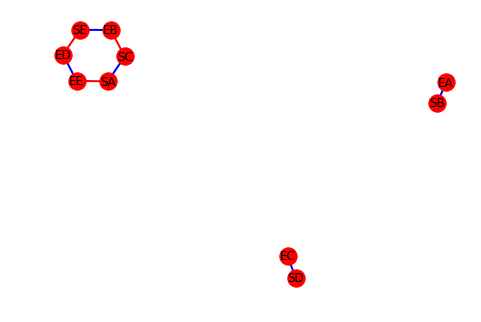

In [261]:
G=nx.Graph()


for i in EDGES1 :
    G.add_edge(i[0],i[1],color='r',weight=2)
    
for j in EDGES2 :
    G.add_edge(j[0],j[1],color='b',weight=2)

edges = G.edges()
colors = [G[u][v]['color'] for u,v in edges]
weights = [G[u][v]['weight'] for u,v in edges]

nx.draw(G,with_labels=True,  edges=edges, edge_color=colors, width=weights)


## Recherche des arc

## Vraies données

In [4]:
def find_edges(S,E, ref = True):
    l = []
    t= S+E
    #print('t',t)
    max_l  = max(t)
    print( 'max_l',max_l)
    max_lID  = t.index(max_l)
    if max_lID < len(t)/2 :
        state_maxl = "S"
    else :
        state_maxl = "E"

    min_l = min(t)
    print( 'min_l',min_l)
    min_lID  = t.index(min_l)
    if min_lID < len(t)/2 :
        state_minl = "S"
    else :
        state_minl = "E"
        
    T = []
    for i in range(len(t)):
        if i < len(t)/2 :
            T.append([t[i],'S'])
        else :
            T.append([t[i],'E'])
            
    #print('Len T', len(t))
    print('T', T[0:20])
    for i in range(len(t)):
        D = []  
        dist =[]
        for j in range(len(t)):
            #print('t.index(t[i])!= t.index(t[j]',t.index(t[i]), t.index(t[j]) )
            if t.index(t[i]) + len(t)/2!= t.index(t[j]) and t.index(t[i])!= t.index(t[j])  :
                if t[i] != max_l and t[i] != min_l and t[j] != max_l and t[j] != min_l : 
                    #print('t[i]', t[i], 't[j]', t[j])
                    #print(t[i]==min_l)
                    d =abs( t[j]- t[i]) 
                    D.append([d, t[j], t[i] ,T[j][1] ,  T[i][1] ])  
                    dist.append(d) 
              
                else :
                    if ref == True :
                        if state_maxl =="E" and state_minl == "S" :
                            #print('in state_maxl =="E" and state_minl == "S" ')
                            p1 = list(data["ID"][data["QEnd"]==max_l] )[0]
                            p1 = "E"+str(p1)
                            p2 = list(data["ID"][data['QAStart']==min_l] )[0]
                            p2 = "S"+str(p2)
                            if (p1, p2) not in l and (p2, p1) not in l:
                                l.append((p1 ,p2) )
                                print('l[-1]', l[-1])
                        elif state_maxl =="S" and state_minl == "E" :
                            #print('in state_maxl =="S" and state_minl == "E"')
                            p1 = list(data["ID"][data["QAStart"]==max_l] )[0]
                            p1 = "S"+str(p1)
                            p2 = list(data["ID"][data['QEnd']==min_l] )[0]
                            p2 = "E"+str(p2)
                            if (p1, p2) not in l and (p2, p1) not in l:
                                l.append((p1 ,p2) )
                                print('l[-1]', l[-1])
                        elif state_maxl =="S" and state_minl == "S" :
                            #print('in state_maxl =="S" and state_minl == "S"')
                            p1 = list(data["ID"][data["QAStart"]==max_l] )[0]
                            p1 = "S"+str(p1)
                            p2 = list(data["ID"][data['QAStart']==min_l] )[0]
                            p2 = "S"+str(p2)
                            if (p1, p2) not in l and (p2, p1) not in l:
                                l.append((p1 ,p2) )
                                print('l[-1]', l[-1])
                        else :
                            #print('in else ')
                            p1 = list(data["ID"][data["QEnd"]==max_l] )[0]
                            p1 = "E"+str(p1)
                            p2 = list(data["ID"][data['QEnd']==min_l] )[0]
                            p2 = "E"+str(p2)
                            if (p1, p2) not in l and (p2, p1) not in l:
                                l.append((p1 ,p2) )
                                print('l[-1]', l[-1])
                    else :
                        if state_maxl =="E" and state_minl == "S" :
                            #print('in state_maxl =="E" and state_minl == "S" ')
                            p1 = list(data["ID"][data["SEnd"]==max_l] )[0]
                            p1 = "E"+str(p1)
                            p2 = list(data["ID"][data['SAStart']==min_l] )[0]
                            p2 = "S"+str(p2)
                            if (p1, p2) not in l and (p2, p1) not in l:
                                l.append((p1 ,p2) )
                                print('l[-1]', l[-1])
                        elif state_maxl =="S" and state_minl == "E" :
                            #print('in state_maxl =="S" and state_minl == "E"')
                            p1 = list(data["ID"][data["SAStart"]==max_l] )[0]
                            p1 = "S"+str(p1)
                            p2 = list(data["ID"][data['SEnd']==min_l] )[0]
                            p2 = "E"+str(p2)
                            if (p1, p2) not in l and (p2, p1) not in l:
                                l.append((p1 ,p2) )
                                print('l[-1]', l[-1])
                        elif state_maxl =="S" and state_minl == "S" :
                            #print('in state_maxl =="S" and state_minl == "S"')
                            p1 = list(data["ID"][data["SAStart"]==max_l] )[0]
                            p1 = "S"+str(P1)
                            p2 = list(data["ID"][data['SAStart']==min_l] )[0]
                            p2 = "S"+str(P2)
                            if  (p1, p2) not in l and (p2, p1) not in l:
                                l.append((p1 ,p2) )
                                print('l[-1]', l[-1])
                        else :
                            #print('in else')
                            p1 = list(data["ID"][data["SEnd"]==max_l] )[0]
                            p1 = "E"+str(p1)
                            p2 = list(data["ID"][data['SEnd']==min_l] )[0]
                            p2 = "E"+str(p2)
                            if  (p1, p2) not in l and (p2, p1)not in l:
                                l.append((p1 ,p2) )
                                print('l[-1]', l[-1])
                    
            else :
                D.append(['NA', 'NA', 'NA', "NA", 'NA'])
                dist.append('NA')
    
        
   
        minD_ID = D[dist.index(min(dist))]
        #print('minD_ID' , minD_ID)  
        if 'NA' not in minD_ID :
            if ref == True :
                if  minD_ID[3] == 'E' and minD_ID[4] == 'S' :
                    p1 = list(data["ID"][data["QEnd"]==minD_ID[1]])[0]
                    p2 = list(data["ID"][data["QAStart"]== minD_ID[2]])[0]
                    if p1 != p2 :
                        p1 = "E"+str(p1)
                        p2 = "S"+str(p2)
                        if  (p1, p2) not in l and (p2, p1) not in l:
                            l.append((p1 ,p2) )
                            print('l[-1]', l[-1])
                elif minD_ID[3] == 'S' and minD_ID[4] == 'E' :
                    p1 = list(data["ID"][data["QAStart"]==minD_ID[1]])[0]
                    p2 = list(data["ID"][data["QEnd"]== minD_ID[2]])[0]
                    if p1 != p2 :
                        p1 = "S"+str(p1)
                        p2 = "E"+str(p2)
                        if  (p1, p2) not in l and (p2, p1) not in l:
                            l.append((p1 ,p2) )
                            print('l[-1]', l[-1])
                elif minD_ID[3] == 'S' and minD_ID[4] == 'S':
                    #print("HERE")
                    p1 = list(data["ID"][data["QAStart"]==minD_ID[1]])[0]
                    p2 = list(data["ID"][data["QAStart"]== minD_ID[2]])[0]
                    if p1 != p2 :
                        p1 = "S"+str(p1)
                        p2 = "S"+str(p2)
                        if  (p1, p2) not in l and (p2, p1) not in l:
                            l.append((p1 ,p2) )
                            print('l[-1]', l[-1])
                else :
                    p1 = list(data["ID"][data["QEnd"]==minD_ID[1]])[0]       
                    p2 = list(data["ID"][data["QEnd"]== minD_ID[2]])[0]
                    if p1 != p2 :
                        p1 = "E"+str(p1)
                        p2 = "E"+str(p2)
                        if  (p1, p2) not in l and (p2, p1) not in l: 
                            l.append((p1 ,p2) )
                            print('l[-1]', l[-1])
                
          
            else :
                if  minD_ID[3] == 'E' and minD_ID[4] == 'S' :
                    p1 = list(data["ID"][data["SEnd"]==minD_ID[1]])[0]
                    p2 = list(data["ID"][data["SAStart"]== minD_ID[2]])[0]
                    if p1 != p2 :
                        p1 = "E"+str(p1)
                        p2 = "S"+str(p2)
                        if  (p1, p2) not in l and (p2, p1) not in l:
                            l.append((p1 ,p2) )
                            print('l[-1]', l[-1])
                elif minD_ID[3] == 'S' and minD_ID[4] == 'E' :
                    p1 = list(data["ID"][data["SAStart"]==minD_ID[1]])[0]
                    p2 = list(data["ID"][data["SEnd"]== minD_ID[2]])[0]
                    if p1 != p2 :
                        p1 = "S"+str(p1)
                        p2 = "E"+str(p2)
                        if  (p1, p2) not in l and (p2, p1) not in l:
                            l.append((p1 ,p2) )
                            print('l[-1]', l[-1])
                elif minD_ID[3] == 'S' and minD_ID[4] == 'S' :
                    #print('HERE')
                    p1 = list(data["ID"][data["SAStart"]==minD_ID[1]])[0]
                    p2 = list(data["ID"][data["SAStart"]== minD_ID[2]])[0]
                    if p1 != p2 :
                        p1 = "S"+str(p1)
                        p2 = "S"+str(p2)
                        if  (p1, p2) not in l and (p2, p1) not in l:
                            l.append((p1 ,p2) )
                            print('l[-1]', l[-1])
                else :
                    p1 = list(data["ID"][data["SEnd"]==minD_ID[1]])[0]
                    p2 = list(data["ID"][data["SEnd"]== minD_ID[2]])[0]
                    if p1 != p2 :
                        p1 = "E"+str(p1)
                        p2 = "E"+str(p2)
                        if  (p1, p2) not in l and (p2, p1) not in l:
                            l.append((p1 ,p2) )
                            print('l[-1]', l[-1])



        
    return l

In [5]:
EDGES1 = find_edges(list(data["QAStart"]), list(data["QEnd"]), True)
print(EDGES1)

('max_l', 4653728)
('min_l', 1)
('T', [[403127, 'S'], [3774352, 'S'], [4502860, 'S'], [1147883, 'S'], [2771520, 'S'], [1504695, 'S'], [2568167, 'S'], [2442375, 'S'], [1736551, 'S'], [581356, 'S'], [4434934, 'S'], [4223294, 'S'], [3153099, 'S'], [3427706, 'S'], [2694632, 'S'], [4000983, 'S'], [4061164, 'S'], [3275087, 'S'], [718877, 'S'], [1655954, 'S']])
('l[-1]', ('E1711', 'S35'))
('l[-1]', ('E475', 'S1'))
('l[-1]', ('E5718', 'S2'))
('l[-1]', ('E5956', 'S3'))
('l[-1]', ('E592', 'S4'))
('l[-1]', ('E1289', 'S5'))
('l[-1]', ('E370', 'S6'))
('l[-1]', ('E76', 'S7'))
('l[-1]', ('E1426', 'S8'))
('l[-1]', ('E44', 'S9'))
('l[-1]', ('E42', 'S10'))
('l[-1]', ('E40', 'S11'))
('l[-1]', ('E1265', 'S12'))
('l[-1]', ('S2006', 'S13'))
('l[-1]', ('S2033', 'S14'))
('l[-1]', ('E337', 'S15'))
('l[-1]', ('E5903', 'S16'))
('l[-1]', ('S1843', 'S17'))
('l[-1]', ('S350', 'S18'))
('l[-1]', ('S5945', 'S19'))
('l[-1]', ('S52', 'S20'))
('l[-1]', ('E1350', 'S21'))


KeyboardInterrupt: 

In [ ]:
EDGES2 = find_edges(list(data["SAStart"]), list(data["SEnd"]), True)
print(EDGES2)